In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import OrdinalEncoder

###MODELS 
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

###DEPLOYMENT
import joblib

In [2]:
df = pd.read_csv("work/Telco_Churn_Prediction/data.csv")
pd.set_option('display.max_columns', None)

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [5]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [6]:
df["Churn"].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [7]:
df["Churn"] = df["Churn"].apply(lambda x: 1 if x == "Yes" else 0)

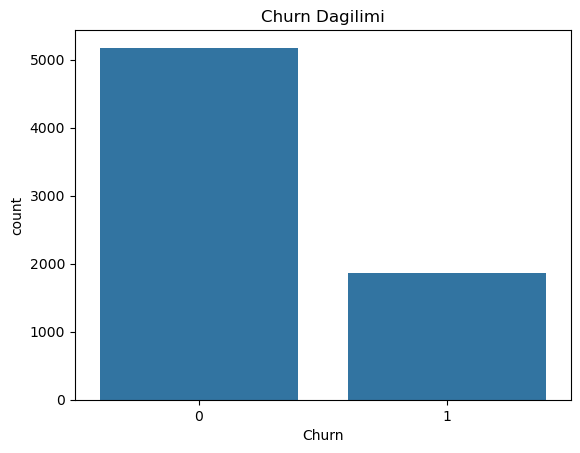

In [8]:
sns.countplot(data=df, x="Churn")
plt.title("Churn Dagilimi")
plt.show()

In [9]:
churn_rate = df['Churn'].value_counts(normalize=True)
print("Churn oranı:\n", churn_rate)

Churn oranı:
 Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


In [10]:
# Drop Columns

selected_features = [
    "gender", "SeniorCitizen", "Partner",
    "tenure", "InternetService", "Contract",
    "MonthlyCharges", "Churn"
]
df = df[selected_features]
df.head()

,gender,SeniorCitizen,Partner,tenure,InternetService,Contract,MonthlyCharges,Churn
0,Female,0,Yes,1,DSL,Month-to-month,29.85,0
1,Male,0,No,34,DSL,One year,56.95,0
2,Male,0,No,2,DSL,Month-to-month,53.85,1
3,Male,0,No,45,DSL,One year,42.30,0
4,Female,0,No,2,Fiber optic,Month-to-month,70.70,1


In [11]:
numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
numerical_cols

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'Churn']

In [12]:
categorical_cols = df.select_dtypes(include='object').columns
categorical_cols

Index(['gender', 'Partner', 'InternetService', 'Contract'], dtype='object')

In [13]:
for col in df.columns:
    print(f"column name: {col} ////// column type: {df[col].dtype}")

column name: gender ////// column type: object
column name: SeniorCitizen ////// column type: int64
column name: Partner ////// column type: object
column name: tenure ////// column type: int64
column name: InternetService ////// column type: object
column name: Contract ////// column type: object
column name: MonthlyCharges ////// column type: float64
column name: Churn ////// column type: int64


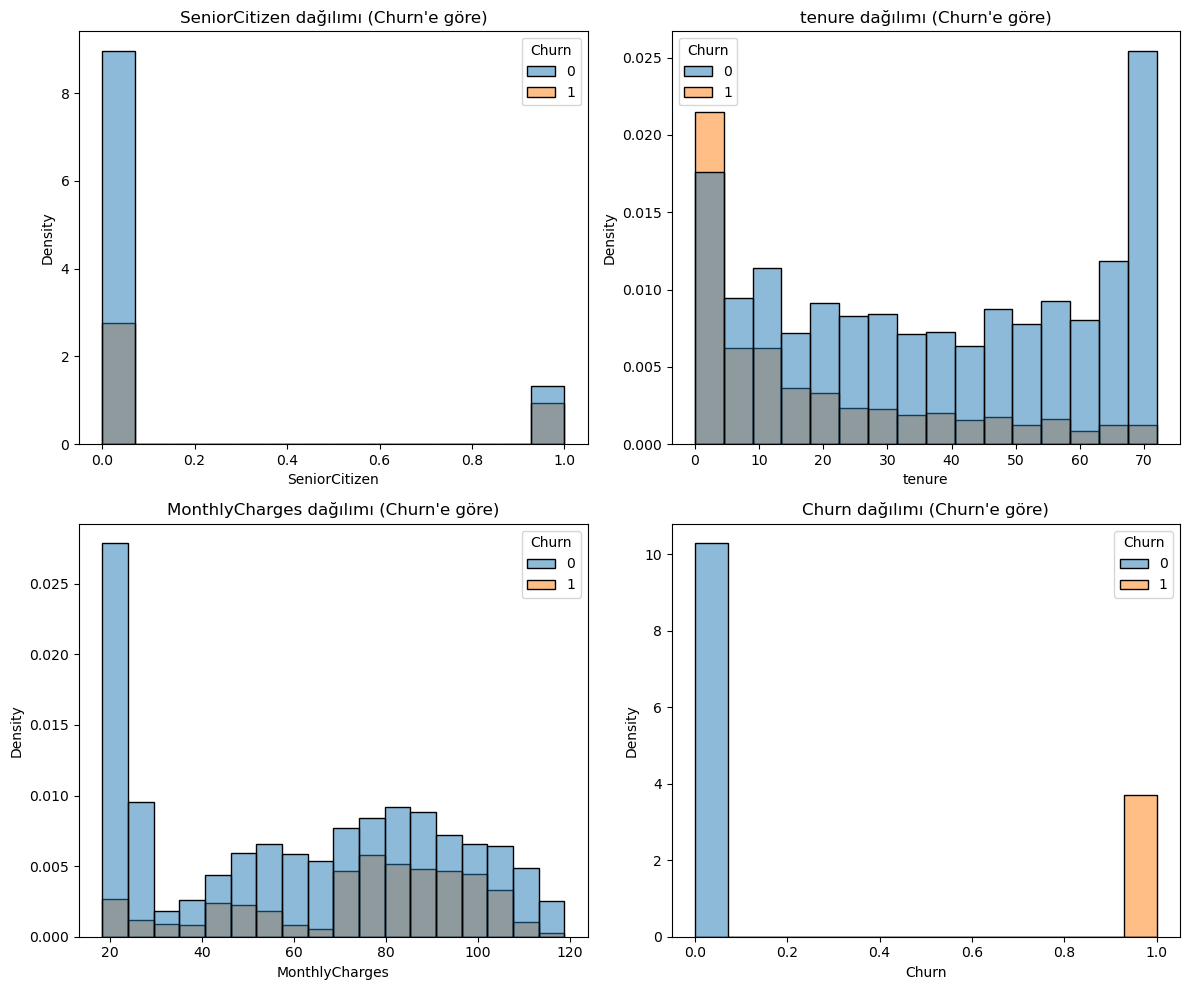

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.histplot(
        data=df,
        x=col,
        hue='Churn',
        kde=False,
        stat='density',
        ax=axes[i]
    )
    axes[i].set_title(f"{col} dağılımı (Churn'e göre)")

plt.tight_layout()
plt.show()

In [15]:
categorical_cols

Index(['gender', 'Partner', 'InternetService', 'Contract'], dtype='object')

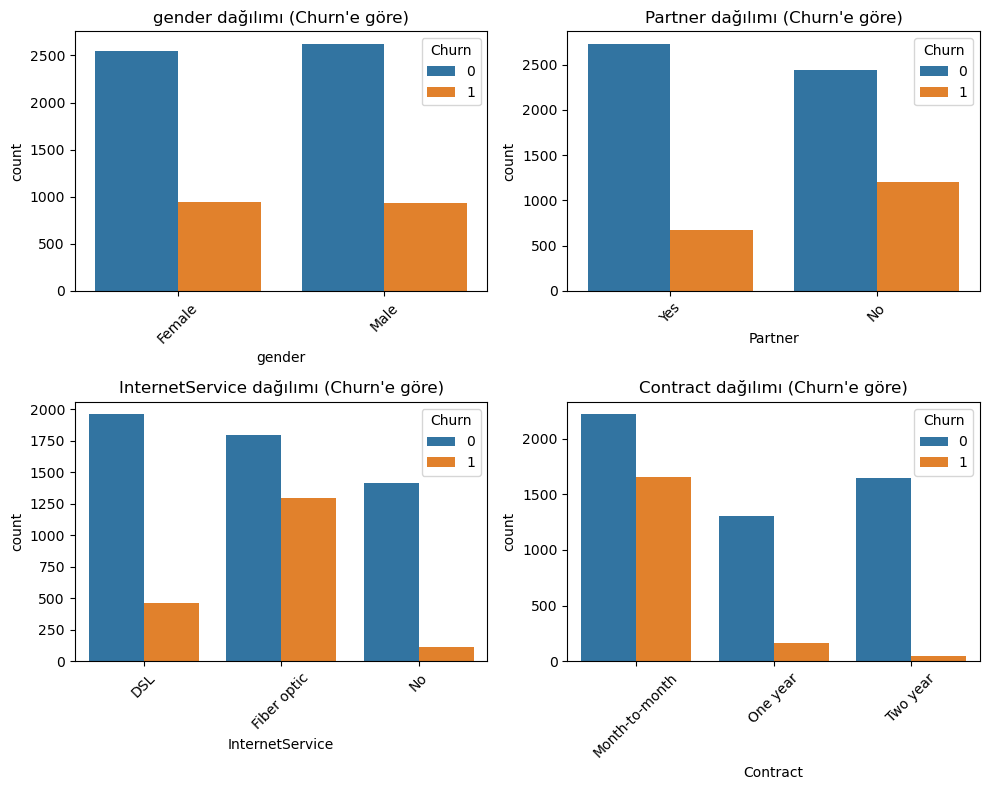

In [16]:
import math
n_cols = 2
n_rows = math.ceil(len(categorical_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))

# Ekseni düzleştir (bazı gridler boş kalabilir)
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(data=df, x=col, hue='Churn', ax=axes[i])
    axes[i].set_title(f"{col} dağılımı (Churn'e göre)")
    axes[i].tick_params(axis='x', rotation=45)

# Eğer bazı eksenler boş kaldıysa, onları kapatalım
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [17]:
############## LABEL ENCODING ##############

In [18]:
encoder = OrdinalEncoder()
df[categorical_cols] = encoder.fit_transform(df[categorical_cols])

# Display category correspondence table for each column
for col, cats in zip(categorical_cols, encoder.categories_):
    print(f"--- {col} ---")
    for i, cat in enumerate(cats):
        print(f"{cat} → {i}")

--- gender ---
Female → 0
Male → 1
--- Partner ---
No → 0
Yes → 1
--- InternetService ---
DSL → 0
Fiber optic → 1
No → 2
--- Contract ---
Month-to-month → 0
One year → 1
Two year → 2


In [19]:
############## SPLIT ##############

In [20]:
X = df.drop(['Churn'], axis=1)
y = df['Churn']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [22]:
X

,gender,SeniorCitizen,Partner,tenure,InternetService,Contract,MonthlyCharges
0,0.0,0,1.0,1,0.0,0.0,29.85
1,1.0,0,0.0,34,0.0,1.0,56.95
2,1.0,0,0.0,2,0.0,0.0,53.85
3,1.0,0,0.0,45,0.0,1.0,42.30
4,0.0,0,0.0,2,1.0,0.0,70.70
...,...,...,...,...,...,...,...
7038,1.0,0,1.0,24,0.0,1.0,84.80
7039,0.0,0,1.0,72,1.0,1.0,103.20
7040,0.0,0,1.0,11,0.0,0.0,29.60
7041,1.0,1,1.0,4,1.0,0.0,74.40


In [23]:
############## MODELLING ##############

In [24]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:08:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [25]:
# Save model
joblib.dump(xgb_model, "/home/jovyan/work/Telco_Churn_Prediction/deployment/models/model.pkl")

['/home/jovyan/work/Telco_Churn_Prediction/deployment/models/model.pkl']

In [26]:
# Save encoder + columns
joblib.dump({"encoder": encoder, "columns": categorical_cols}, 
            "/home/jovyan/work/Telco_Churn_Prediction/deployment/models/ordinal_encoder.pkl")


['/home/jovyan/work/Telco_Churn_Prediction/deployment/models/ordinal_encoder.pkl']